### Import libraries

In [468]:
from typing import List, Optional, Tuple, Union, Callable
import random
import requests

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch as t
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import einops
import color

### Visualization utilities

In [167]:
%%capture
!wget -O blue.png https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Solid_blue.svg/225px-Solid_blue.svg.png

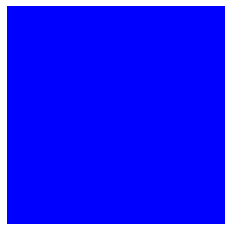

In [168]:
def imshow(img: Union[np.ndarray, t.Tensor], **kwargs):
    if isinstance(img, t.Tensor):
        img = img.cpu()

    with t.no_grad():
        if len(img.shape) == 4:
            img = einops.rearrange(img, "1 ... -> ...")

        if img.shape[0] == 3:
            img = einops.rearrange(img, "c h w -> h w c")

        #plt.figure(figsize=figsize)
        plt.margins(tight=True)
        plt.imshow(img, **kwargs)
        plt.axis("off")


# plt.imshow(np.stack([np.eye(100) for _ in range(3)], axis=-1))
imshow(matplotlib.image.imread("blue.png"))


### Load network and imagenet data

In [169]:
resnet34 = torchvision.models.resnet34(pretrained=True).cuda()
resnet34.eval();

In [170]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)
imagenet_labels[9]

'ostrich, Struthio camelus'

### Image parameterizations

In [494]:
def optimize_image(
    img_class,
    loss_fn: Optional[Callable[[t.Tensor], t.Tensor]] = None,
    steps: int = 10,
    class_index: int = 250,
    figsize: Tuple[int, int] = (5, 5),
    dpi: int = 100,
    interpolation: str = "nearest",
    transform: bool = True,
    n_transforms: int = 100,
    transforms_list: Optional[List] = None,
    lr: float = 1e-1,
):
    if loss_fn is None:
        loss_fn = lambda image : resnet34(image)[:, class_index]
    
    if transforms_list is None:
        transforms_list = [
            transforms.RandomAffine(
                degrees=30, translate=(0.5, 0.5), scale=(0.75, 1), shear=15
            ),
            transforms.RandomPerspective(),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
            ),
        ]

    image_module = img_class().cuda()

    orig_image = image_module().clone()
    optimizer = optim.Adam(image_module.parameters(), lr=lr)

    for _ in tqdm(range(steps)):
        optimizer.zero_grad()
        image = image_module()

        if transform:
            transformed_imgs = []
            for _ in range(n_transforms):
                tr = random.choice(transforms_list)
                transformed_imgs.append(tr(image_module()))

            batch = t.cat(transformed_imgs, dim=0)
            loss = -loss_fn(batch).mean()
        else:
            loss = -loss_fn(image_module()).mean()
        loss.backward()

        optimizer.step()

    orig_loss = loss_fn(orig_image)[0]
    final_loss = loss_fn(image)[0]
    plt.figure(figsize=figsize, dpi=dpi)

    ax = plt.subplot(2, 2, 1)
    ax.set_title(f"Original: logit={orig_loss:.3f}")
    imshow(orig_image, interpolation=interpolation)

    ax = plt.subplot(2, 2, 2)
    ax.set_title(f"Final: logit={final_loss:.3f}")
    imshow(image, interpolation=interpolation)

    ax = plt.subplot(2, 2, 3)
    orig_image = color.rgb_to_hsv(orig_image)
    plt.hist(
        orig_image[:, 0].flatten().detach().cpu().numpy() / 2 / np.pi,
        label="h",
        bins=128,
        alpha=0.5,
    )
    plt.hist(
        orig_image[:, 1].flatten().detach().cpu().numpy(),
        label="s",
        bins=128,
        alpha=0.5,
    )
    plt.hist(
        orig_image[:, 2].flatten().detach().cpu().numpy(),
        label="v",
        bins=128,
        alpha=0.5,
    )

    ax = plt.subplot(2, 2, 4)
    image = color.rgb_to_hsv(image)
    plt.hist(
        image[:, 0].flatten().detach().cpu().numpy() / 2 / np.pi,
        label="h",
        bins=128,
        alpha=0.5,
    )
    plt.hist(
        image[:, 1].flatten().detach().cpu().numpy(),
        label="s",
        bins=128,
        alpha=0.5,
    )
    plt.hist(
        image[:, 2].flatten().detach().cpu().numpy(),
        label="v",
        bins=128,
        alpha=0.5,
    )


100%|██████████| 100/100 [00:01<00:00, 51.01it/s]


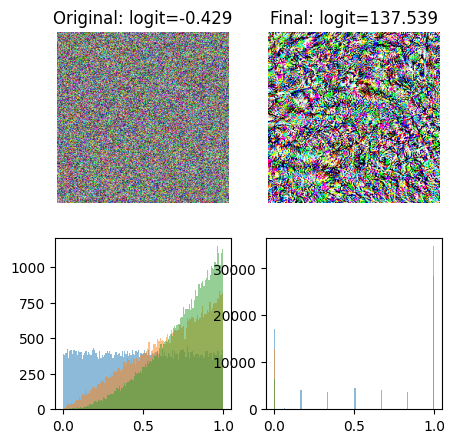

In [495]:
class NaiveImage(nn.Module):
    def __init__(
        self,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
    ):
        super().__init__()
        self.data: nn.parameter.Parameter = nn.Parameter(t.rand(size=image_shape))

    def forward(self):
        return self.data.clip(min=0, max=1)


optimize_image(NaiveImage, steps=100, interpolation='antialiased', transform=False)

In [496]:
optimize_image(NaiveImage, steps=500, interpolation='antialiased', transform=True)

 10%|█         | 51/500 [00:14<02:04,  3.60it/s]


KeyboardInterrupt: 

100%|██████████| 5/5 [00:00<00:00, 47.40it/s]


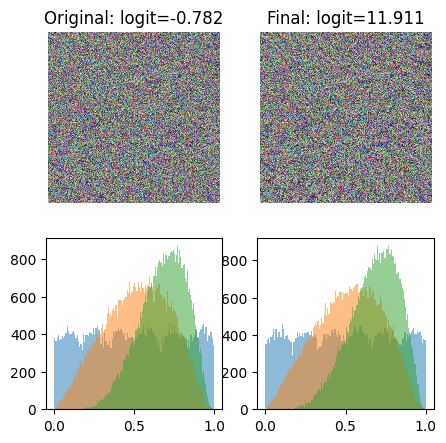

In [497]:
class SigmoidImage(nn.Module):
    def __init__(
        self,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
    ):
        super().__init__()
        self.data: nn.parameter.Parameter = nn.Parameter(t.randn(size=image_shape))

    def forward(self):
        return t.sigmoid(self.data)

optimize_image(SigmoidImage, steps=5, transform=False)

100%|██████████| 500/500 [00:26<00:00, 18.68it/s]


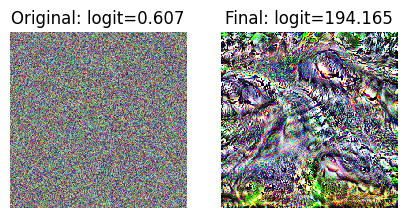

In [198]:
optimize_image(SigmoidImage, steps=500, transform=True)

100%|██████████| 100/100 [00:04<00:00, 20.43it/s]


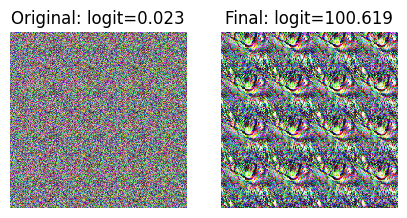

In [199]:
class TiledImage(nn.Module):
    def __init__(
        self,
        ratio: int,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
    ):
        super().__init__()

        self.image_shape = image_shape
        self.tile_shape = (image_shape[0], image_shape[1], image_shape[2] // ratio, image_shape[3] // ratio)
        self.data: nn.parameter.Parameter = nn.Parameter(t.randn(size=self.tile_shape))

    def forward(self):
        return t.sigmoid(
            einops.repeat(
                self.data,
                "1 c h w -> 1 c (i h) (j w)",
                i=self.image_shape[2] // self.tile_shape[2],
                j=self.image_shape[3] // self.tile_shape[3],
            )
        )

optimize_image(lambda: TiledImage(ratio=4), steps=100, transform=True)

100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


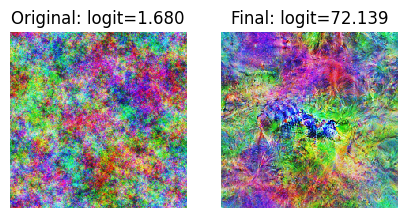

In [384]:
class FourierImage(nn.Module):
    def __init__(
        self,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
        normalize: bool = True,
        init_std: float = 0.05,
    ):
        super().__init__()
        init = (
            t.randn(
                size=(
                    image_shape[0],
                    image_shape[1],
                    image_shape[2],
                    image_shape[3] // 2 + 1,
                    2,
                ),
            )
            * init_std
        )

        self.normalize = normalize
        if self.normalize:
            H = image_shape[2]
            W = image_shape[3]

            fx = t.fft.fftfreq(W)
            fy = t.fft.fftfreq(H)

            sos = t.zeros(image_shape)
            sos += fx.reshape(1, 1, 1, -1) ** 2
            sos += fy.reshape(1, 1, -1, 1) ** 2

            self.norm_factor: t.Tensor
            self.register_buffer(
                "norm_factor",
                (1 / t.sqrt(sos)[:, :, :, : init.shape[-2]]).unsqueeze(dim=-1),
            )
            self.norm_factor[:, :, 0, 0] = 1

        self.data: nn.parameter.Parameter = nn.Parameter(init)

    def normalize_fn(self, xs: t.Tensor):
        return (xs - xs.mean()) / xs.std()

    def forward(self, ret_raw_logits: bool = False):
        coeffs = self.data
        if self.normalize:
            coeffs = self.data * self.norm_factor

        raw_logits = t.fft.irfft2(t.view_as_complex(coeffs), norm="ortho")
        if ret_raw_logits:
            return raw_logits

        norm_logits = self.normalize_fn(raw_logits)
        return t.sigmoid(norm_logits)


optimize_image(FourierImage, steps=10, transform=True, lr=1e-1)
# plt.hist(FourierImage()().flatten().numpy(), bins=128)


100%|██████████| 500/500 [00:28<00:00, 17.54it/s]


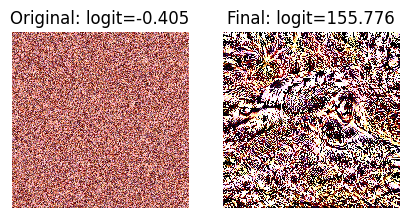

In [333]:
PROJECTION = t.tensor([[0.26, 0.09, 0.02], [0.27, 0.00, -0.05], [0.27, -0.09, 0.03]])*4

class DecorrelatedImage(nn.Module):
    def __init__(
        self,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
    ):
        super().__init__()
        self.data: nn.parameter.Parameter = nn.Parameter(t.randn(size=image_shape))
        self.register_buffer(
            "projection", PROJECTION
        )

    def forward(self):
        projected=t.einsum('i j, b j h w -> b i h w', self.projection, t.sigmoid(self.data))
        #plt.hist(projected.detach().cpu().numpy().flatten())
        #plt.show()
        #plt.hist(projected.detach().cpu().numpy().flatten())
        #plt.show()
        return t.clip(projected, 0,1)


optimize_image(DecorrelatedImage, steps=500, transform=True, lr=0.5)


100%|██████████| 1000/1000 [00:58<00:00, 17.17it/s]


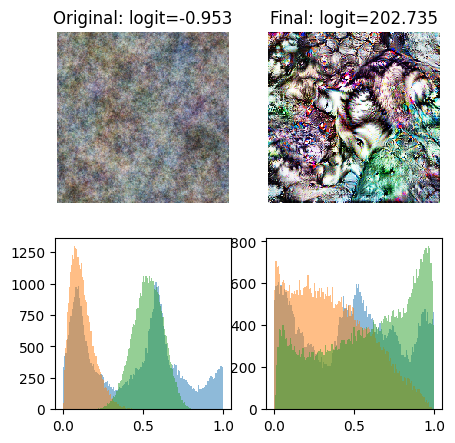

In [499]:
class FourierDecorrImage(nn.Module):
    def __init__(
        self,
        image_shape: Tuple[int, int, int, int] = (1, 3, 224, 224),
        normalize: bool = True,
    ):
        super().__init__()
        init = (
            t.randn(
                size=(
                    image_shape[0],
                    image_shape[1],
                    image_shape[2],
                    image_shape[3] // 2 + 1,
                    2,
                ),
            ) / 20
        )

        self.normalize = normalize
        if self.normalize:
            H = image_shape[2]
            W = image_shape[3]

            fx = t.fft.fftfreq(W)
            fy = t.fft.fftfreq(H)

            sos = t.zeros(image_shape)
            sos += fx.reshape(1, 1, 1, -1) ** 2
            sos += fy.reshape(1, 1, -1, 1) ** 2

            self.norm_factor: t.Tensor
            self.register_buffer(
                "norm_factor",
                (1 / t.sqrt(sos)[:, :, :, : init.shape[-2]]).unsqueeze(dim=-1),
            )
            self.norm_factor[:, :, 0, 0] = 1

        
        self.data: nn.parameter.Parameter = nn.Parameter(init)
        self.register_buffer(
            "projection", PROJECTION
        )

    def forward(self):
        coeffs = self.data
        if self.normalize:
            coeffs = self.data * self.norm_factor

        decorr = t.fft.irfft2(t.view_as_complex(coeffs), norm="ortho")
        rgb=t.einsum('i j, b j h w -> b i h w', self.projection, decorr)
        return t.sigmoid(rgb)

optimize_image(FourierDecorrImage, steps=1000, transform=True, lr=0.01, n_transforms=10)
# plt.hist(FourierImage()().flatten().numpy(), bins=128)


100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


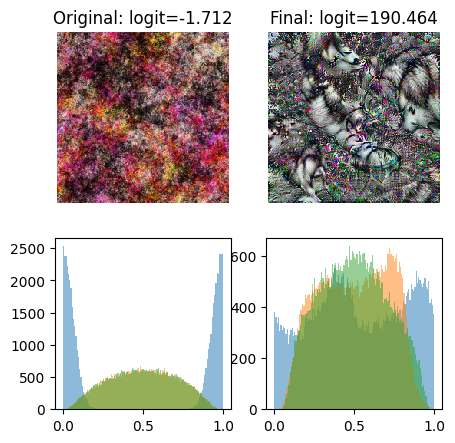

In [500]:
TMP = None

class FourierHSVImage(FourierImage):
    def forward(self):
        raw_logits = super().forward(ret_raw_logits=True)

        HSV = t.cat(
            (
                raw_logits[:, 0:1] % (2 * t.pi),
                t.sigmoid(self.normalize_fn(raw_logits[:, 1:2]) ),
                t.sigmoid(self.normalize_fn(raw_logits[:, 2:]) ),
            ),
            dim=1,
        )

        global TMP
        TMP = HSV

        return color.hsv_to_rgb(HSV)


optimize_image(
    FourierHSVImage,
    steps=1000,
    transform=True,
    lr=0.05,
    n_transforms=10,
)


In [480]:
def get_resnet_layer_output(resnet, layer_str,  input, channel_index=0):
    saved_output=None
    def hook(self, input, output):
        nonlocal saved_output
        saved_output=output
    name_list = layer_str.split(".")
    thing=resnet
    for name in name_list:
        thing=getattr(thing, name)

    thing.register_forward_hook(hook)
    resnet(input)

    saved_output= t.mean(F.relu(saved_output), dim=[-2,-1])
    return saved_output[:,channel_index]
    


In [481]:
output = get_resnet_layer_output(resnet34, 'layer1.0.bn1', FourierHSVImage()().cuda())
print(output.shape)
loss_fn = lambda image : get_resnet_layer_output(resnet34, 'layer1.0.bn1', image)


torch.Size([1])


100%|██████████| 1000/1000 [01:06<00:00, 15.00it/s]


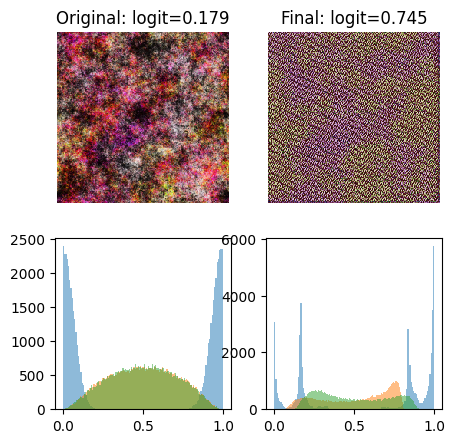

In [487]:

optimize_image(
    FourierHSVImage,
    loss_fn,
    steps=1000,
    transform=True,
    lr=0.01,
    n_transforms=10,
)

100%|██████████| 500/500 [00:35<00:00, 14.18it/s]


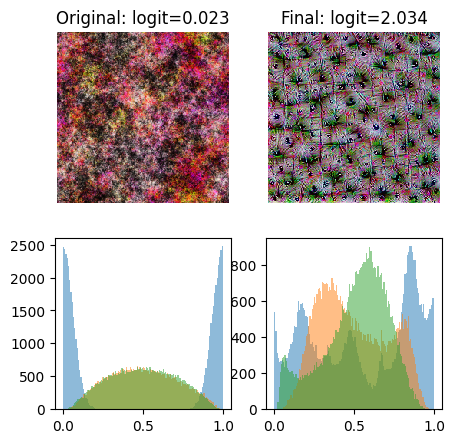

In [491]:
loss_fn = lambda image : get_resnet_layer_output(resnet34, 'layer3.0.bn1', image)
optimize_image(
    FourierHSVImage,
    loss_fn,
    steps=500,
    transform=True,
    lr=0.05,
    n_transforms=10,
)

100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


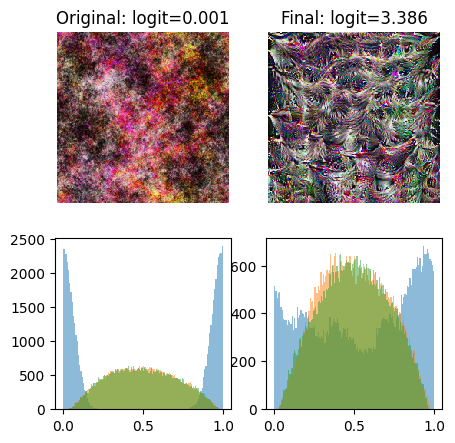

In [492]:
loss_fn = lambda image : get_resnet_layer_output(resnet34, 'layer4.0.bn1', image)
optimize_image(
    FourierHSVImage,
    loss_fn,
    steps=100,
    transform=True,
    lr=0.05,
    n_transforms=10,
)

100%|██████████| 500/500 [00:35<00:00, 14.06it/s]


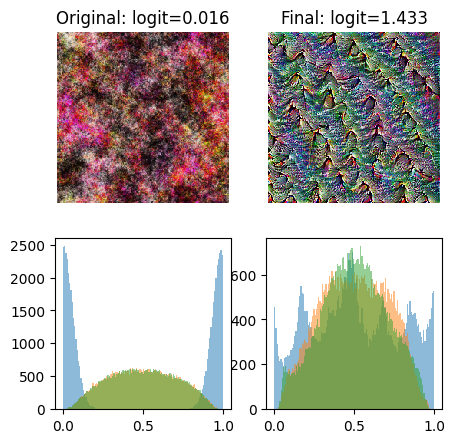

In [493]:
loss_fn = lambda image : get_resnet_layer_output(resnet34, 'layer3.0.bn1', image, channel_index=1)
optimize_image(
    FourierHSVImage,
    loss_fn,
    steps=500,
    transform=True,
    lr=0.05,
    n_transforms=10,
)